## Image Segmentation for Medical diagnosis using PyTorch

In [187]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.checkpoint import checkpoint
from torch import optim
from torch.utils.data import random_split
from torchvision.transforms import transforms
from torchinfo import summary
from collections import defaultdict
import matplotlib.pyplot as plt
import cv2
import glob
import json
import pathlib
from time import time

### Downlaod the CVC clinic dataset and extract

In [188]:
# !curl -L -o ~/Downloads/cvcclinicdb.zip\
#   https://www.kaggle.com/api/v1/datasets/download/balraj98/cvcclinicdb
# !mkdir data
# !unzip ~/Downloads/cvcclinicdb.zip -d data

In [189]:
with open("./config.json","r") as f:
    config = json.load(f)
config
image_path = config['data_path']+"Original/"
mask_path  = config['data_path']+"Ground Truth/"
images = glob.glob(image_path+"*"+config['file_extn'])
masks  = glob.glob(mask_path+"*"+config['file_extn'])

## Create CVC custom dataset and pre process

In [190]:
"""
Make CVC dataset
"""

class CVCDataset(Dataset):
    def __init__(self, images, image_transforms=None, mask_transforms=None):
        super(CVCDataset, self).__init__()
        self.images = images
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_split = img_path.split('/')
        img_name = img_split[-1]
        img_dir = '/'.join(img_split[:-2])
        mask_path = img_dir+"/Ground Truth/"+img_name
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.image_transforms:
            image = self.image_transforms(image)
        if self.mask_transforms:
            mask = self.mask_transforms(mask)

        return image, mask


### Create train and test set

In [191]:
# Custom transform to threshold the mask

class ThresholdTransform(object):
  def __init__(self, thr=0.5):
    self.thr = thr

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type


image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    #transforms.Normalize()
])

mask_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    ThresholdTransform()
])

imgset = CVCDataset(images, image_transforms, mask_transforms)
trainset, testset = random_split(imgset, [0.9, 0.1])
batch_size = 16
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=True)

### Check image and mask sample

In [192]:
data, mask = next(iter(train_loader))
data = torch.einsum("chw->hwc", data[0])
mask = torch.einsum("chw->hwc", mask[0])

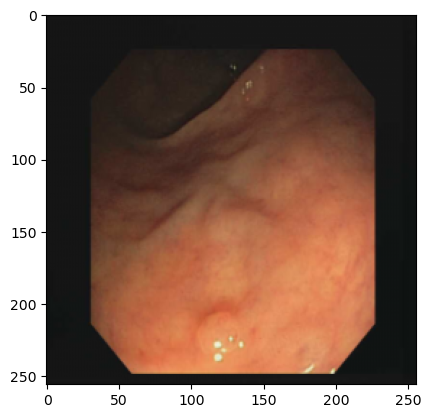

In [193]:
plt.imshow(data)

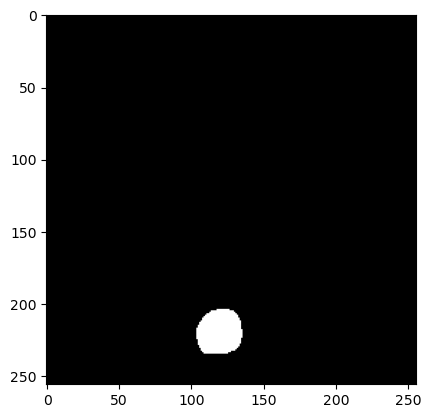

In [194]:
plt.imshow(mask, cmap='gray')

In [195]:
mask[mask == 1].shape

torch.Size([823])

In [196]:
""" Parts of the U-Net model """

class DoubleConv(nn.Module):
    """(conv => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """ Downscaling with maxpool """

    def __init__(self):
        super(Down,self).__init__()
        self.down = nn.MaxPool2d(2)
    
    def forward(self, x):
        return self.down(x)


class DownDoubleConv(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super(DownDoubleConv, self).__init__()
        self.down_doubleconv = nn.Sequential(
            Down(),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down_doubleconv(x)


class UpDoubleConv(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super(UpDoubleConv, self).__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.double_conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is BCHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.double_conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [197]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, checkpointing=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.checkpointing = checkpointing

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (DownDoubleConv(64, 128))
        self.down2 = (DownDoubleConv(128, 256))
        self.down3 = (DownDoubleConv(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (DownDoubleConv(512, 1024 // factor))
        self.up1 = (UpDoubleConv(1024, 512 // factor, bilinear))
        self.up2 = (UpDoubleConv(512, 256 // factor, bilinear))
        self.up3 = (UpDoubleConv(256, 128 // factor, bilinear))
        self.up4 = (UpDoubleConv(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        if self.checkpointing:
            x1 = checkpoint(self.inc, x, use_reentrant=False)
            x2 = checkpoint(self.down1, x1, use_reentrant=False)
            x3 = checkpoint(self.down2, x2, use_reentrant=False)
            x4 = checkpoint(self.down3, x3, use_reentrant=False)
            x5 = checkpoint(self.down4, x4, use_reentrant=False)
            x = checkpoint(self.up1, x5,x4, use_reentrant=False)
            x = checkpoint(self.up2, x,x3, use_reentrant=False)
            x = checkpoint(self.up3, x,x2, use_reentrant=False)
            x = checkpoint(self.up4, x,x1, use_reentrant=False)
            logits = checkpoint(self.outc, x, use_reentrant=False)
            return logits

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [198]:
# # test model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# test_input = torch.randn((64, 3, 256, 256)).to(device)
# test_model = UNet(3,1,checkpointing=True).to(device)
# print(summary(test_model))
# torch.cuda.reset_peak_memory_stats()
# test_out = test_model(test_input)
# print(f"Peak Memory Usage With Checkpointing: {torch.cuda.max_memory_allocated()/1e6} MB")
# print(test_out.shape)

In [199]:
def save_plots(losses, name=None):
    pathlib.Path("results").mkdir(parents=True, exist_ok=True)
    if not name:
        timestr = time.strftime("%Y%m%d-%H%M%S")
        save_plot_path = "results/plot-"+timestr
    else:
        save_plot_path = "results/"+name
    epochs = len(losses['train_loss'])
    plt.plot(range(1,epochs+1), losses['train_loss'], label='Train loss')
    plt.plot(range(1,epochs+1), losses['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Losses")
    plt.savefig(save_plot_path, facecolor='w', edgecolor='none')
    plt.show()

def save_model(model, name=None):
    pathlib.Path("results/saved_models").mkdir(parents=True, exist_ok=True)
    if not name:
        timestr = time.strftime("%Y%m%d-%H%M%S")
        save_model_path = "results/saved_models/"+timestr+".pth"
    else:
        save_model_path = "results/saved_models/"+name+".pth"
    torch.save(model.state_dict(), save_model_path)

In [200]:
def train_model(model, device, train_loader, loss_criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    total = 0
    total_acc = 0
    epoch_losses = []
    for batchidx, (data, target) in enumerate(train_loader):
        #print(f'batch id: {batchidx}')
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        predictions = output.argmax(dim=1, keepdim=True)
        #print(f'predictions: {predictions.shape}, target: {target.shape}')
        correct = predictions.eq(target.view_as(predictions)).sum().item()
        total_acc += (correct/len(data))
        total += len(data)
    avg_acc = total_acc/len(train_loader)
    avg_loss = train_loss/total
    print(f"Train epoch: {epoch} [{(batchidx+1) * len(data)}/{len(train_loader.dataset)}\
          ({(100. * batchidx/len(train_loader)):.0f}%)]\tLoss: {avg_loss:.6f}\tAcc: {100. * avg_acc:.6f}%")
    return 100. * avg_acc, avg_loss

def test_model(model, device, test_loader, loss_criterion):
    model.eval()
    test_loss = 0.
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criterion(output, target).item()
            predictions = output.argmax(dim=1, keepdim=True)
            #print(f'predictions: {predictions.shape}, target: {target.shape}')
            correct += predictions.eq(target.view_as(predictions)).sum().item()
            total += len(data)
    test_loss /= total
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({100. * correct/total:.0f}%)")
    return 100. * correct/total, test_loss


In [201]:
# num_classes = 1
# learning_rate = 0.01
# num_epochs = 2
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# loss_criterion = nn.BCEWithLogitsLoss()
# inp_channels = 3
# model = UNet(inp_channels, num_classes, checkpointing=True).to(device)
# optimizer = optim.Adam(model.parameters(),lr=learning_rate)
# print(f"using device: {device}")
# data, targets = next(iter(train_loader))
# data, targets = data.to(device), targets.to(device)
# predictions = model(data)
# loss = loss_criterion(predictions, targets)


using device: cuda
Layer (type:depth-idx)                        Param #
UNet                                          --
├─DoubleConv: 1-1                             --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       1,728
│    │    └─BatchNorm2d: 3-2                  128
│    │    └─ReLU: 3-3                         --
│    │    └─Conv2d: 3-4                       36,864
│    │    └─BatchNorm2d: 3-5                  128
│    │    └─ReLU: 3-6                         --
├─DownDoubleConv: 1-2                         --
│    └─Sequential: 2-2                        --
│    │    └─Down: 3-7                         --
│    │    └─DoubleConv: 3-8                   221,696
├─DownDoubleConv: 1-3                         --
│    └─Sequential: 2-3                        --
│    │    └─Down: 3-9                         --
│    │    └─DoubleConv: 3-10                  885,760
├─DownDoubleConv: 1-4                         --
│    └─Sequential: 2-4    

/home/codez/anaconda3/envs/mlenv/lib/python3.10/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Train epoch: 1 [544/551          (97%)]	Loss: 0.017257	Acc: 5956419.301471%
Test set: Average loss: 0.0202, Accuracy: 2855744/48 (5949467%)
Train epoch: 2 [544/551          (97%)]	Loss: 0.013590	Acc: 5956091.360294%
Test set: Average loss: 0.0128, Accuracy: 2871438/48 (5982162%)


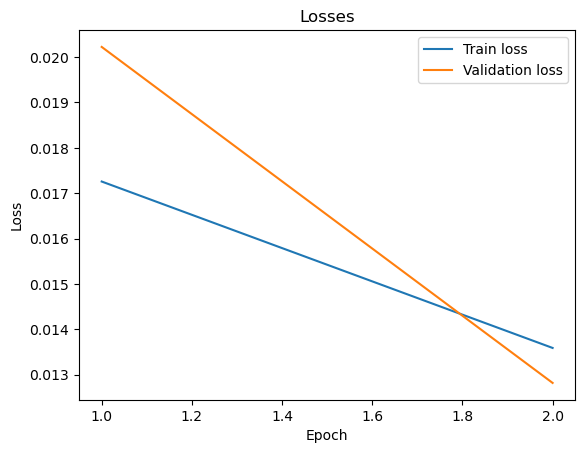

In [202]:
num_classes = 1
learning_rate = 0.01
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_criterion = nn.BCEWithLogitsLoss()
inp_channels = 3
model = UNet(inp_channels, num_classes, checkpointing=True).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

losses = defaultdict(list)

print(f"using device: {device}")
print(summary(model))

for epoch in range(1,num_epochs+1):
    _, tloss = train_model(model, device, train_loader, loss_criterion, optimizer, epoch)
    losses['train_loss'].append(tloss)
    _, vloss = test_model(model, device, test_loader, loss_criterion)
    losses['val_loss'].append(vloss)

# save plots
save_plots(losses, 'mnist-loss')

#save model
save_model(model, 'mnist_sample_model')